# Monte Carlo Simulation with MCX (PMCX)

This notebook demonstrates how to set up and run a light-transport Monte Carlo simulation using **Monte Carlo eXtreme (MCX)** through its Python interface, the `pmcx` package.

MCX is a photon-transport simulator for light propagation in turbid media, accelerated on GPUs. Here, we will build a simple cubic volume with two tissue types (a background tissue and a central inclusion) and compute the light fluence distribution.

### **Environment prerequisites**
Because MCX uses CUDA for massive parallelization, GPU acceleration must be enabled in this notebook:

1. Go to **Runtime**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, choose **T4 GPU** (or another available NVIDIA GPU).


## 1. Installing Dependencies

We will install the `pmcx` package, which bundles the compiled MCX binaries and the utilities needed to read/write the JSON/Binary data formats used by the simulator.


In [1]:
# Install the MCX Python interface and visualization libraries
!pip install -q pmcx numpy matplotlib jdata bjdata iso2mesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 92.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 14.2 MB/s eta 0:00:00


## 2. Importing and Checking the GPU

Before running the simulation, we verify that the environment correctly detects the NVIDIA GPU.

MCX requires a CUDA-capable GPU to run.

The `pmcx.gpuinfo()` function lists the available devices.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pmcx

# Check available GPUs
gpu_info = pmcx.gpuinfo()
print("GPUs found:")
print(gpu_info)

if not gpu_info:
    print("WARNING: No NVIDIA GPU detected. MCX may not run or may be slow.")

GPUs found:
[{'name': 'Tesla T4', 'id': 1, 'devcount': 1, 'major': 7, 'minor': 5, 'globalmem': 15828320256, 'constmem': 65536, 'sharedmem': 49152, 'regcount': 65536, 'clock': 1590000, 'sm': 40, 'core': 2560, 'autoblock': 64, 'autothread': 81920, 'maxgate': 0}]


## 3. Volume and Simulation Configuration

In this step we define the physical world of the simulation and the MCX settings.

### **A. Defining the Volume (`vol`)

The domain is represented by a 3D voxel grid (`uint8` array).
- **Value 1:** Base tissue.
- **Value 2:** A central inclusion (for example, a tumor or heterogeneity).
- **Value 0:** Reserved for background/air (outside the volume or where set to 0).

### **B. Configuration Dictionary (`cfg`)

`pmcx` uses a Python dictionary to pass parameters to the MCX binary. Key fields include:

* **`nphoton`**: Total number of photons to launch (higher means less noise but longer runtime).
* **`tstart`, `tend`, `tstep`**: Time window of the simulation; for continuous-wave (CW) cases we integrate over time or use a single long step.
* **`srcpos` & `srcdir`**: Source position and direction. The default is a pencil beam.
* **`prop`**: Optical properties table. Each row corresponds to a label/index in the volume:
    * Format: `[mua, mus, g, n]` (Absorption, Scattering, Anisotropy, Refractive Index).
    * **Row 0:** Always reserved for the outside medium (Air/Background).
    * **Row 1:** Properties of voxels with value 1.
    * **Row 2:** Properties of voxels with value 2.
* **`autopilot`**: Lets MCX automatically choose an ideal number of GPU threads and blocks for the detected device.


In [3]:
# 1. Defining the Volume (60x60x60 voxel grid)
# Initialize everything as medium 1 (baseline tissue)
vol = np.ones([60, 60, 60], dtype='uint8')

# Add a central inclusion (medium 2)
# Coordinates: x, y, z from 20 to 40
vol[20:40, 20:40, 20:40] = 2

# 2. Setting Simulation Parameters (cfg dictionary)
cfg = {
    'nphoton': 1e7,          # Number of photons (10 million)
    'vol': vol,              # Volume defined above
    'tstart': 0,             # Start time (s)
    'tend': 5e-9,            # End time (5 ns)
    'tstep': 5e-9,           # Time step (same as total for CW)
    'srcpos': [30, 30, 0],   # Source position (x, y, z) on the surface
    'srcdir': [0, 0, 1],     # Source direction (downward, +z)

    # Optical Properties [mua, mus, g, n]
    # Row 0: Background (Air) -> [0, 0, 1, 1]
    # Row 1: Base Tissue -> low absorption, high scattering
    # Row 2: Inclusion -> higher absorption (e.g., tumor)
    'prop': [
        [0, 0, 1, 1],             # Medium 0 (Air/Background)
        [0.005, 1.0, 0.9, 1.37],  # Medium 1 (Normal Tissue)
        [0.05, 2.0, 0.9, 1.37]    # Medium 2 (Inclusion/Heterogeneity)
    ],

    'issrcfrom0': 1,         # Set origin of the coordinate system at [0, 0, 0]
    'autopilot': 1,          # Let MCX pick optimal threads/blocks
    'gpuid': 1               # Use the first available GPU
}
print(cfg.keys())

dict_keys(['nphoton', 'vol', 'tstart', 'tend', 'tstep', 'srcpos', 'srcdir', 'prop', 'issrcfrom0', 'autopilot', 'gpuid'])


## 4. Running the Simulation

The `pmcx.run(cfg)` function translates the configuration dictionary, launches the Monte Carlo simulation, and returns the results in Python.

The returned object `res` is a dictionary that contains the requested data (for example, photon flux/fluence) as well as execution metadata.


In [4]:
# Run the simulation
# The result 'res' is a dictionary containing fluence and other data
res = pmcx.run(cfg)

print("Simulation finished!")
# Inspect returned keys (e.g., 'flux', 'stat', etc.)
print("Returned data keys:", res.keys())
print('Stat', res['stat'])

nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
autopilot: 1
Simulation finished!
Returned data keys: dict_keys(['flux', 'stat'])
Stat {'runtime': 521, 'nphoton': 10000000, 'energytot': 10000000.0, 'energyabs': 4326197.627815247, 'normalizer': 20.0, 'unitinmm': 1.0, 'workload': [2560.0]}


## 5. Visualizing the Results

The main result is stored under the `flux` key. It is a 4D array `[..., ..., ..., Nt]` containing the **fluence rate** in each voxel.

To visualize it:
1. Extract a 2D slice through the center of the volume (plane Y=30).
2. Apply a logarithmic scale (`np.log10`), since light attenuates exponentially as it propagates through tissue.
3. Display a heatmap to observe the energy distribution and the effect of the central inclusion.
...

In the next code block, we will automate running the simulation three consecutive times.

We will use a loop to dynamically change the `outputtype` key in the configuration (`cfg`).

The goal is to keep the same volume and optical properties while changing the physical quantity computed by MCX (Flux, Fluence, or Energy).


## 6. Visualizing the Simulated Volume (Comparison)

To better interpret the fluence result, we will visualize the simulated volume itself, showing where the inclusion (Medium 2) is located.


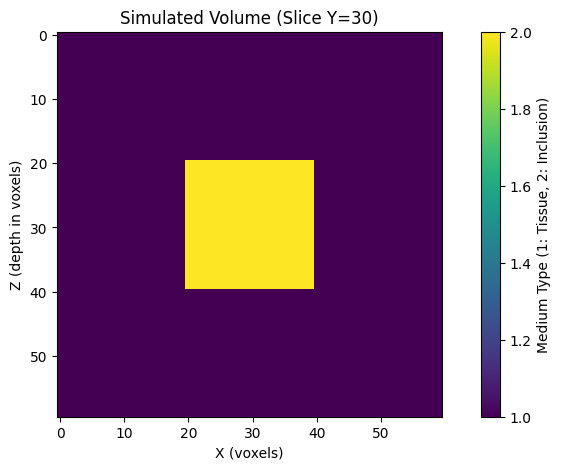

In [5]:
plt.figure(figsize=(10, 5))
plt.imshow(vol[:, 30, :].T, cmap='viridis', origin='upper')
plt.colorbar(label='Medium Type (1: Tissue, 2: Inclusion)')
plt.title('Simulated Volume (Slice Y=30)')
plt.xlabel('X (voxels)')
plt.ylabel('Z (depth in voxels)')
plt.show()

Now we can compare this volume visualization with the fluence map. Notice how the inclusion modifies the light distribution due to its higher absorption and scattering optical properties.


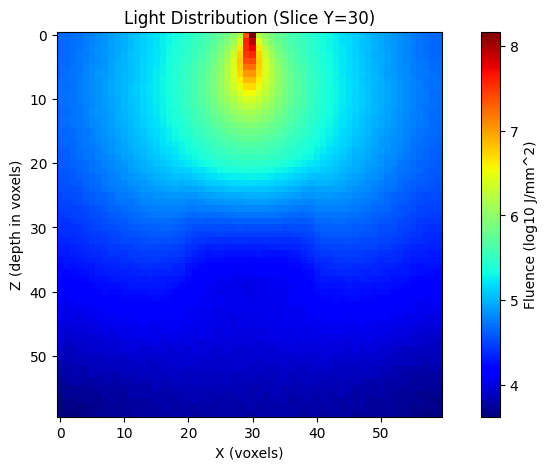

In [6]:
# Extract the fluence (flux) map
# Typical shape is [Nx, Ny, Nz, Nt]
fluence = res['flux']

# Select a slice on the Y plane (y=30, middle of the volume)
# Use log10 because light decays exponentially
slice_y = np.log10(fluence[:, 30, :, 0])

plt.figure(figsize=(10, 5))
plt.imshow(slice_y.T, cmap='jet', origin='upper')  # Transpose to orient z and x correctly
plt.colorbar(label='Fluence (log10 J/mm^2)')
plt.title('Light Distribution (Slice Y=30)')
plt.xlabel('X (voxels)')
plt.ylabel('Z (depth in voxels)')
plt.show()

# 7. Comparing Output Types (Physics)

MCX can return different physical quantities depending on the selected output type. Here we compare three: **Flux**, **Fluence**, and **Energy**.

### **1. Flux (Fluence Rate) - $\Phi(\vec{r}, t)$**
* **What it is:** The default MCX quantity, representing the power crossing an imaginary sphere at a point in space per unit area.
* **Units:** $W/mm^2$ (energy sources) or $1/(mm^2 \cdot s)$ (photon sources).

A useful rule of thumb is to keep **Simulation** separate from **Analysis**.

### **Why does this matter?**
1. **Computational cost:** Monte Carlo simulations with billions of photons can take minutes to hours; you do not want to rerun them just to change a plot color.
2. **Immutability:** Preserve the raw simulation output. You can change analysis later while keeping results comparable.
3. **Portability:** MCX uses the **NeuroJSON** standard (JSON/BJData files), readable by MATLAB, Python, or even browsers, which eases sharing.

Below we save the simulation result to disk and then simulate a “new day” by reloading the data for analysis.


## Running the Comparison

In the next code block, we will automate running the simulation three times in a row.

We will use a loop to dynamically change the `outputtype` key in the configuration (`cfg`).

The goal is to keep the same volume and optical properties while changing the physical quantity computed by MCX (Flux, Fluence, or Energy).


In [7]:
# Base configuration (same as defined earlier)
# Ensure medium 2 has absorption so the Energy output shows a difference
cfg_base = cfg.copy()
cfg_base['gpuid'] = 1
cfg_base['autopilot'] = 1

# Dictionary to store results
results = {}
types = ['flux', 'fluence', 'energy']

print("Starting output comparison...")

for out_type in types:
    print(f"Simulating: {out_type}...")

    # Update output type
    current_cfg = cfg_base.copy()
    current_cfg['outputtype'] = out_type

    # Run simulation
    res_temp = pmcx.run(current_cfg)

    # MCX always returns the key 'flux'; the numeric content reflects the requested output type.
    # Store the 3D volume (sum over time for a static view)
    data_4d = res_temp['flux']
    results[out_type] = np.sum(data_4d, axis=3)

print("Simulations finished.")

Starting output comparison...
Simulating: flux...
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
autopilot: 1
Simulating: fluence...
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
autopilot: 1
Simulating: energy...
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
autopilot: 1
Simulations finished.


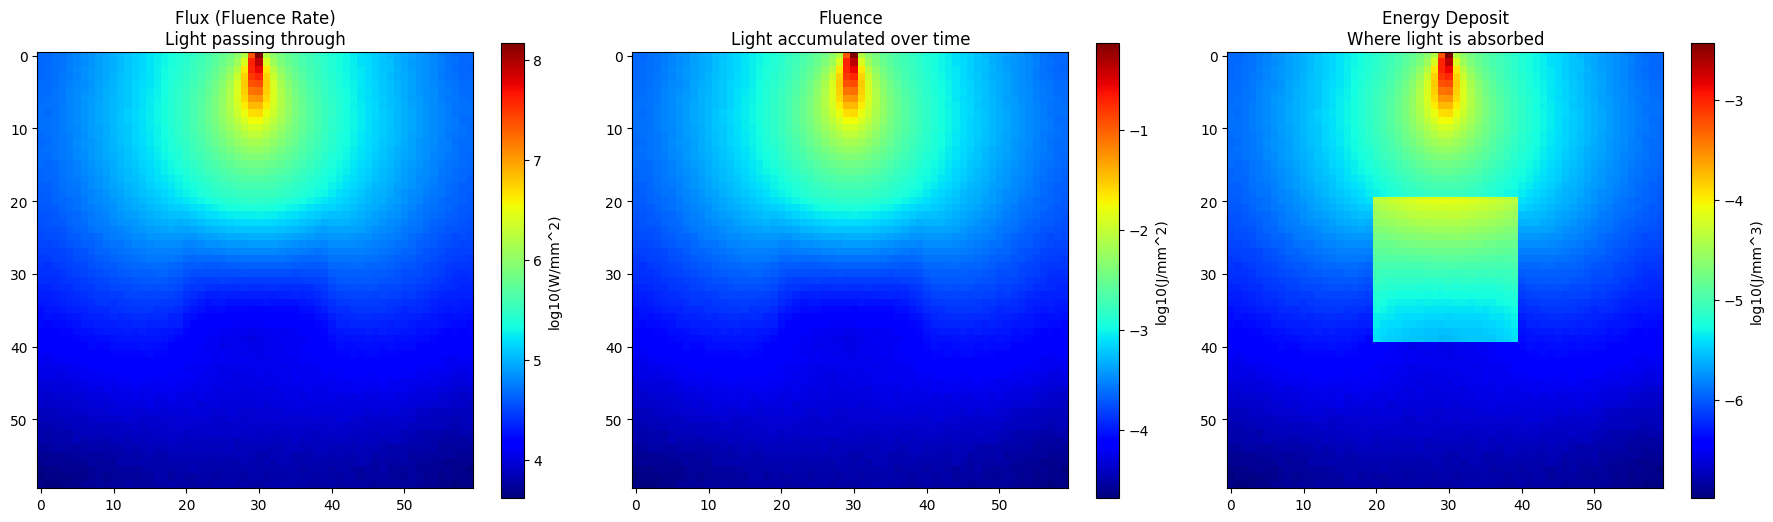

--- Analysis at Inclusion Center ---
Flux (Available light): 3.46e+04
Energy (Absorbed light): 8.66e-06
Note: Energy highlights the inclusion because mu_a is higher there (0.05 vs 0.005).


In [8]:
# Comparative plot (Transverse slice Y=30)
slice_idx = 30

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Flux
im1 = axes[0].imshow(np.log10(results['flux'][:, slice_idx, :] + 1e-15).T, cmap='jet', origin='upper')
axes[0].set_title('Flux (Fluence Rate)\nLight passing through')
fig.colorbar(im1, ax=axes[0], label='log10(W/mm^2)')

# 2. Fluence
im2 = axes[1].imshow(np.log10(results['fluence'][:, slice_idx, :] + 1e-15).T, cmap='jet', origin='upper')
axes[1].set_title('Fluence\nLight accumulated over time')
fig.colorbar(im2, ax=axes[1], label='log10(J/mm^2)')

# 3. Energy
# Energy is often viewed linearly or in log scale depending on contrast
im3 = axes[2].imshow(np.log10(results['energy'][:, slice_idx, :] + 1e-15).T, cmap='jet', origin='upper')
axes[2].set_title('Energy Deposit\nWhere light is absorbed')
fig.colorbar(im3, ax=axes[2], label='log10(J/mm^3)')

plt.tight_layout()
plt.show()

# Brief numeric analysis at the center of the inclusion (about 30, 30, 30)
# The inclusion spans [20:40, 20:40, 20:40]
center_flux = results['flux'][30, 30, 30]
center_energy = results['energy'][30, 30, 30]

print("--- Analysis at Inclusion Center ---")
print(f"Flux (Available light): {center_flux:.2e}")
print(f"Energy (Absorbed light): {center_energy:.2e}")
print("Note: Energy highlights the inclusion because mu_a is higher there (0.05 vs 0.005).")

## Interpreting the Visual Results

When looking at the plots, focus on how the optical properties influence the outcome. The **Energy** map strongly highlights the central inclusion because it has higher absorption, while the **Flux/Fluence** maps emphasize propagation and attenuation patterns.


# 7. Good Practices: Reproducibility and Data Persistence

A key best practice is to store simulation outputs in a stable, shareable format. This makes it easy to reproduce figures, compare parameter sweeps, and share results with collaborators without requiring them to rerun expensive simulations.

In the next section, we will persist the raw outputs and demonstrate loading them again for downstream analysis.


Saving raw data to disk...
File 'mcx_tumor_simulation.bnii' saved successfully!
Data removed from RAM (simulating closing the notebook).
Loading data from file...
Recovered keys: dict_keys(['flux', 'fluence', 'energy'])


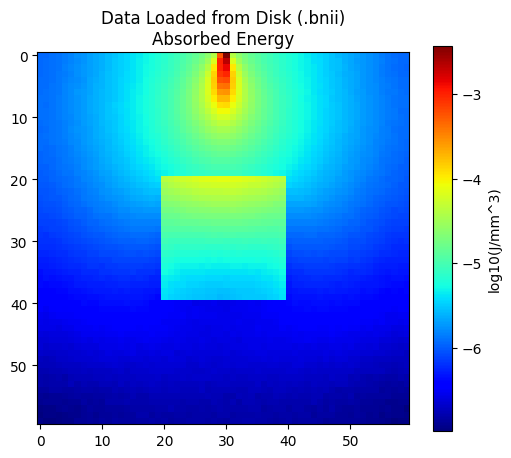

In [9]:
import jdata

# --- STEP 1: Save the result (persistence) ---
# Save the most recent simulation results (Energy) to disk.
# The .bnii (Binary NeuroJSON) format is fast and efficient for large arrays.

print("Saving raw data to disk...")
file_name = 'mcx_tumor_simulation.bnii'

# Save the full dictionary containing the three computed output types
jdata.save(results, file_name)

print(f"File '{file_name}' saved successfully!")

# --- STEP 2: "Forget" the data (simulate a fresh session) ---
# Clear the variable from memory to prove loading works
del results
print("Data removed from RAM (simulating closing the notebook).")

# --- STEP 3: Load for analysis (reproducibility) ---
print("Loading data from file...")
loaded_data = jdata.load(file_name)

# Verification
print("Recovered keys:", loaded_data.keys())

# --- STEP 4: Quick re-analysis ---
# Plot again without recomputing physics (which requires the GPU)
import matplotlib.pyplot as plt
import numpy as np

energy_map = loaded_data['energy']
slice_idx = 30

plt.figure(figsize=(6, 5))
plt.imshow(np.log10(energy_map[:, slice_idx, :] + 1e-15).T, cmap='jet', origin='upper')
plt.title('Data Loaded from Disk (.bnii)\nAbsorbed Energy')
plt.colorbar(label='log10(J/mm^3)')
plt.show()

### Format Details
We use the **BJData (Binary JData)** format, with the `.bnii` extension.

This format is part of the NeuroJSON initiative, led by the author of MCX.

It allows storing complex N-dimensional arrays along with metadata, and provides efficient compression for large volumetric datasets.


# 8. Advanced Modeling with `Shapes`

So far, we created our volume (`vol`) manually using array... high-level commands, called **JSON Shape Descriptors**.

### **Advantages**
1.  **Simplicity:** Instead of computing matrix indices for ... sphere, you just say: “I want a sphere in the center with radius 10”.
2.  **Resolution independence:** If you change the grid size, shapes automatically scale, unlike a fixed voxel array.
3.  **Human readability:** It is easy to understand what is being simulated by reading the code.

### **How does it work?**
Instead of passing the `vol` array, we pass two new keys in the `cfg` dictionary:
* **`dim`**: Grid dimensions (e.g., `[60, 60, 60]`).
* **`shapes`**: A list of dictionaries, where each item is a geometric primitive.

### **Priority Order (Painter’s Algorithm)**
MCX processes the `shapes` list in order. Shapes drawn later **overwrite** earlier ones.
* *Example:* If you fill everything with Tissue 1 and then draw a Tissue 2 sphere, the sphere will “carve out” the base tissue.

### **Common Commands**
* **`Grid`**: Fills the entire grid with a value (`Tag`).
* **`Sphere`**: Creates a sphere (`O`: center, `R`: radius).
* **`Box`**: Creates a box/cube (`O`: corner, `Size`: dimensions).
* **`ZLayers`**: Creates layers along the Z axis (useful for skin/brain-like layered models).
* **`Cylinder`**: Creates a cylinder (`C0`, `C1`: endpoints, `R`: radius).


In [10]:
import numpy as np
import pmcx
import jdata as jd

# ------------------------------------------------------------
# 1) Base configuration
# ------------------------------------------------------------
cfg = {
    'nphoton': int(1e7),

    # Base volume (implicitly defines dimensions)
    'vol': np.zeros((60, 60, 60), dtype='uint8'),

    # Time window
    'tstart': 0.0,
    'tend': 5e-9,
    'tstep': 5e-9,

    # Source
    'srcpos': [30, 30, 0],
    'srcdir': [0, 0, 1],

    # Optical properties (index = tissue tag)
    'prop': [
        [0,    0,   1,   1],     # Tag 0: Air
        [0.1, 10.0, 0.9, 1.4],   # Tag 1: Epidermis
        [0.01, 2.0, 0.9, 1.37],  # Tag 2: Dermis
        [0.05, 5.0, 0.9, 1.37],  # Tag 3: Tumor
    ],

    # Additional parameters
    'dumpmask': 1,          # Request the processed volume (mask/vol) back
    'autopilot': 1,
    'gpuid': 1,
    'outputtype': 'fluence',
}

# ------------------------------------------------------------
# 2) Define shapes
# ------------------------------------------------------------
shape = []
shape.append({'Grid': {'Tag': 0, 'Size': [60, 60, 60]}})
shape.append({'ZLayers': [[0, 10, 1], [11, 60, 2]]})
shape.append({'Sphere': {'O': [30, 30, 30], 'R': 8, 'Tag': 3}})

# Serialize shapes in the format expected by MCX/pmcx
cfg['shapes'] = jd.show({'Shapes': shape}, {'string': True})

# -----------------------------------------------------------
# 3) Execution
# ------------------------------------------------------------
print("Running simulation with dumpmask=1...")
res_gpu = pmcx.run(cfg)
print("Simulation finished!")

print("Available keys in the result:", list(res_gpu.keys()))

if 'vol' in res_gpu:
    print("Success! The volume was returned (key 'vol').")
else:
    print("Warning: The key 'vol' was not found in the result.")


Running simulation with dumpmask=1...
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
autopilot: 1
Simulation finished!
Available keys in the result: ['vol', 'flux', 'stat']
Success! The volume was returned (key 'vol').


**Visualizing the Complex Geometry**

Here we will visualize the result. Because Shapes creates the geometri... it will behave differently, revealing the anatomy we built.


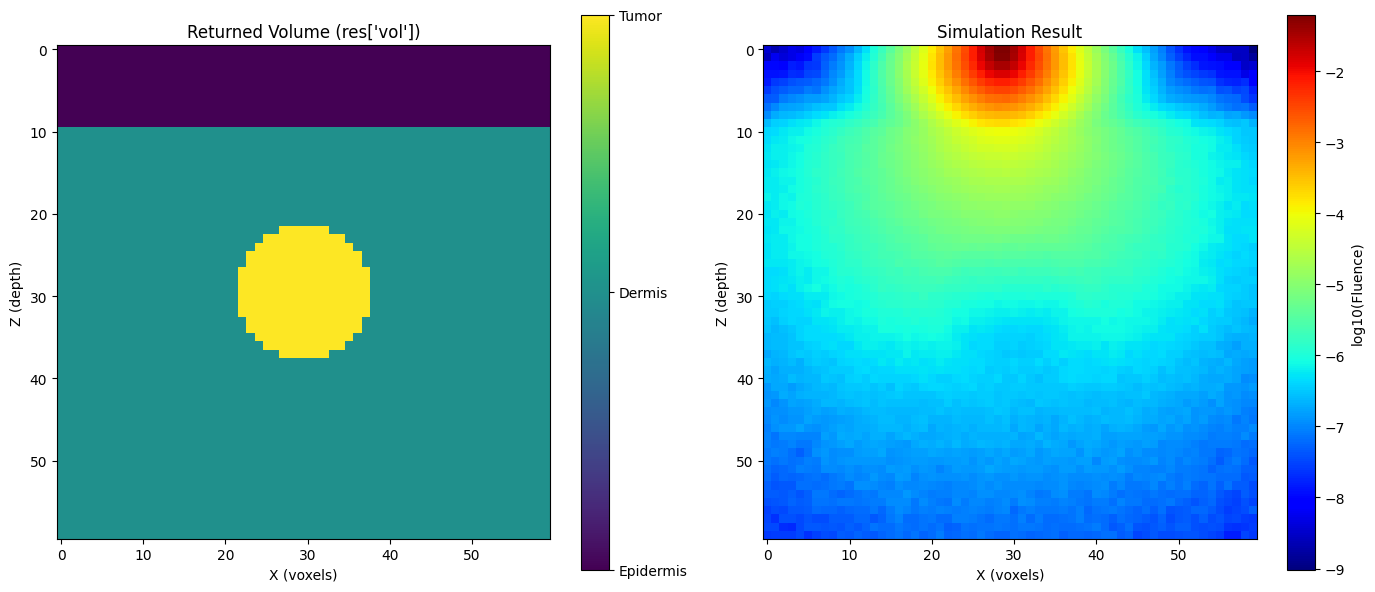

Now we know for sure the simulation ran on exactly this geometry.


In [11]:
# Access the actual volume returned by the simulation
# It arrives as uint8 (integers 0 to 255)
real_gpu_vol = res_gpu['vol']

# Access the fluence result
real_fluence = res_gpu['flux']

# Prepare plots (Slice Y=30)
slice_idx = 30
img_vol_gpu = real_gpu_vol[:, slice_idx, :].T
img_flu_gpu = np.log10(np.sum(real_fluence, axis=3)[:, slice_idx, :] + 1e-15).T

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Volume returned by the GPU (ground truth)
im1 = axes[0].imshow(img_vol_gpu, origin='upper')
axes[0].set_title("Returned Volume (res['vol'])")
axes[0].set_xlabel('X (voxels)')
axes[0].set_ylabel('Z (depth)')
cbar1 = fig.colorbar(im1, ax=axes[0], ticks=[0, 1, 2, 3])
cbar1.ax.set_yticklabels(['Air', 'Epidermis', 'Dermis', 'Tumor'])

# Plot 2: Fluence
im2 = axes[1].imshow(img_flu_gpu, cmap='jet', origin='upper')
axes[1].set_title('Simulation Result')
axes[1].set_xlabel('X (voxels)')
axes[1].set_ylabel('Z (depth)')
fig.colorbar(im2, ax=axes[1], label='log10(Fluence)')

plt.tight_layout()
plt.show()

print("Now we know for sure the simulation ran on exactly this geometry.")